In [1]:
# Import important libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import config
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from darts.metrics import mase,ope,r2_score,mape
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel, TFTModel, NaiveSeasonal, NaiveDrift, ExponentialSmoothing, TBATS, AutoARIMA, Theta

In [2]:
data_filename = 'df_item_veg_samosa.pkl'

In [5]:
df_item = pd.read_pickle(config.DATA+'//data//'+data_filename)

In [6]:
df_item['Total Count'].describe()

count    316.000000
mean      11.612605
std        6.749917
min        0.000000
25%        8.000000
50%       12.000000
75%       16.000000
max       34.000000
Name: Total Count, dtype: float64

In [19]:
df_item= df_item.loc['2021-11-24 08:00:00': '2022-08-31 23:59:00']

In [20]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df_item,freq='D',fill_missing_dates=True)
series2 = series.add_holidays('IN','KA')


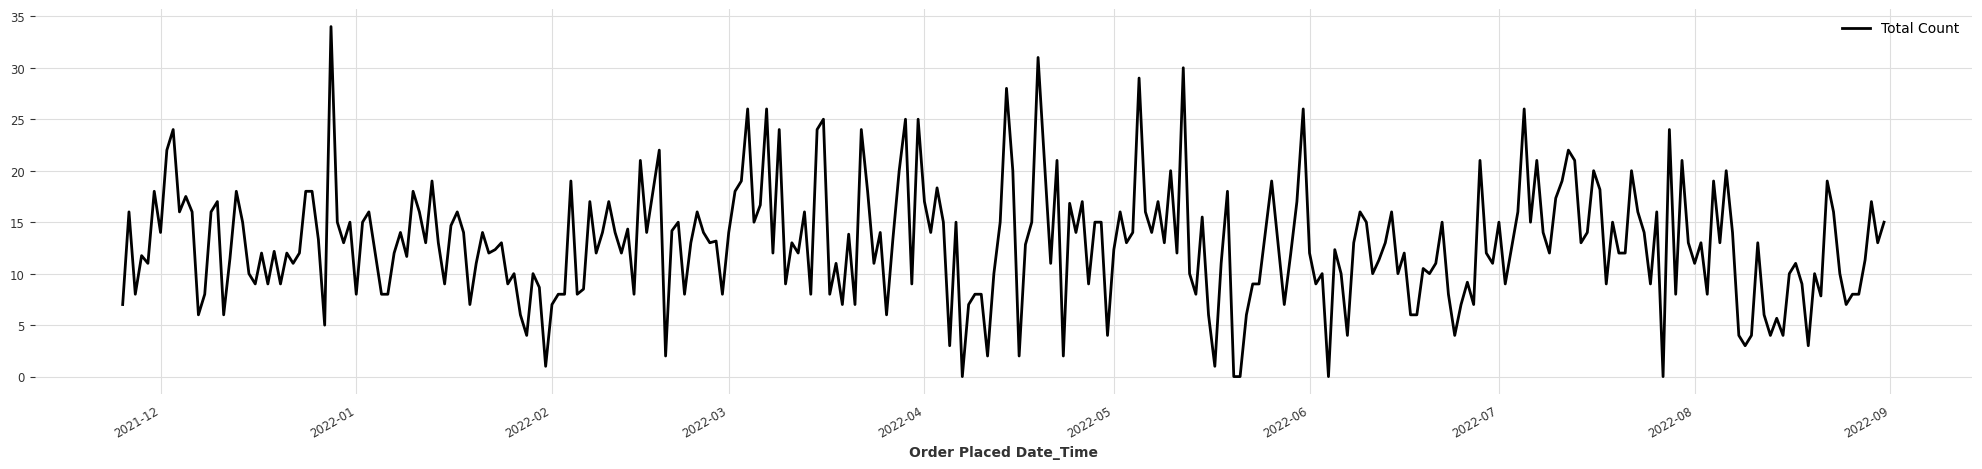

In [21]:
fig = plt.figure(figsize=(25,5))
series.plot()


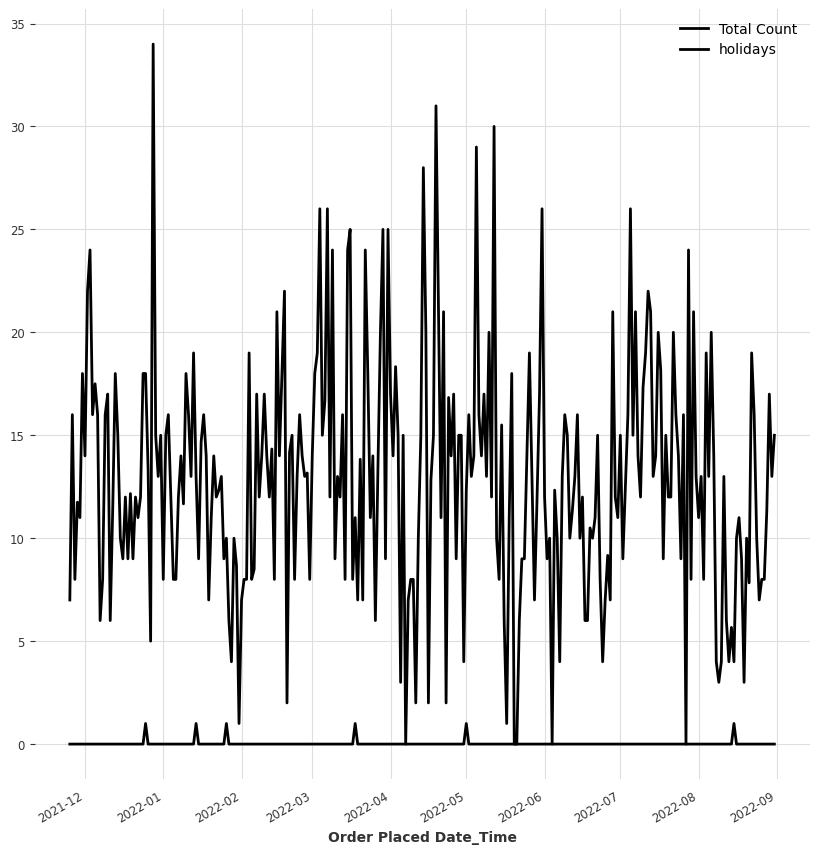

In [22]:
fig = plt.figure(figsize=(10,10))   
ax = fig.add_subplot()
series2.plot(linestyle = '-', color = 'black')


In [23]:
# Test train split (75%)
train, val = series.split_before(0.75)

Text(0, 0.5, 'Item Count')

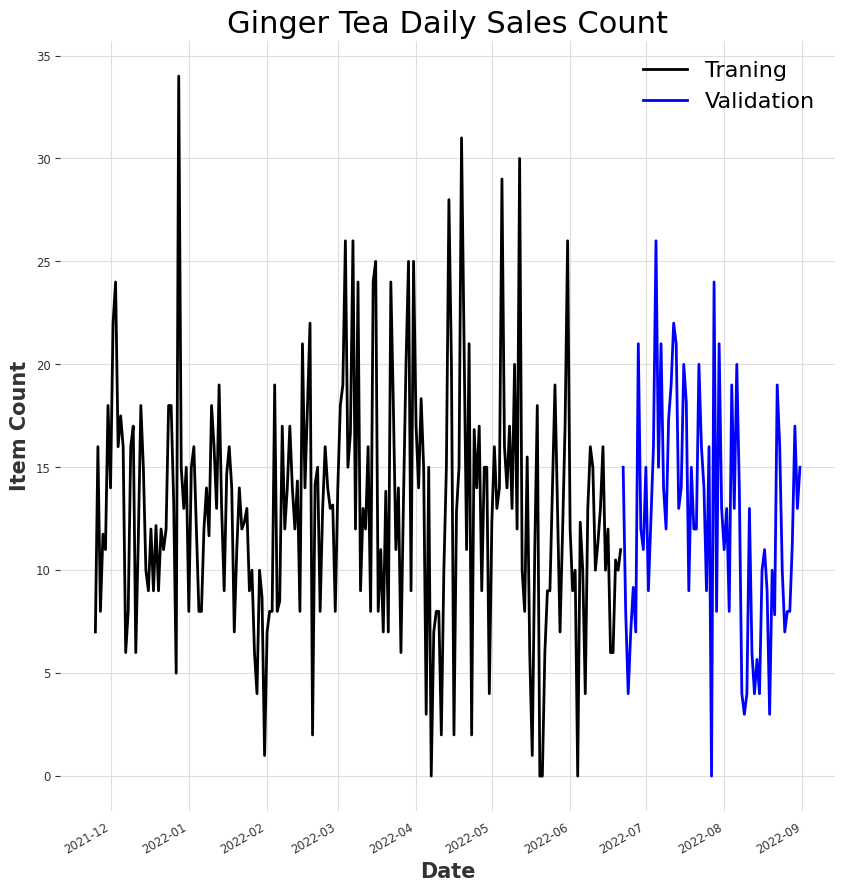

In [24]:
fig = plt.figure(figsize=(10,10))   
train.plot(linestyle = '-', color = 'black')
val.plot(linestyle = '-', color = 'blue')
plt.title('Ginger Tea Daily Sales Count',fontsize = 22)
plt.legend(loc=0, prop={'size': 16},labels= ['Traning','Validation','Holiday_train','Holiday_val'])
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Item Count',fontsize = 15)

## Naive Baseline Model

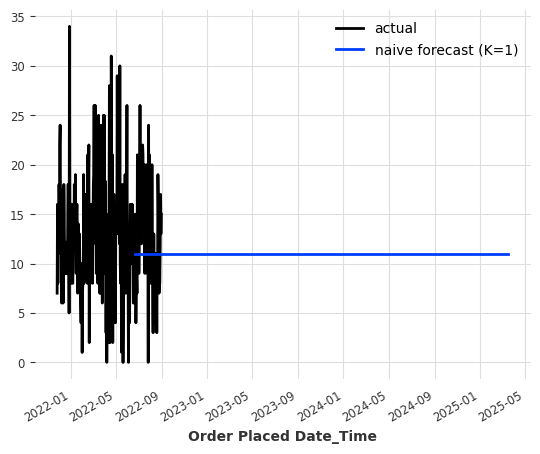

In [25]:
# Naive model for k = 1 seasonality
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(1000)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

There is seasonality of order 3.
There is seasonality of order 6.


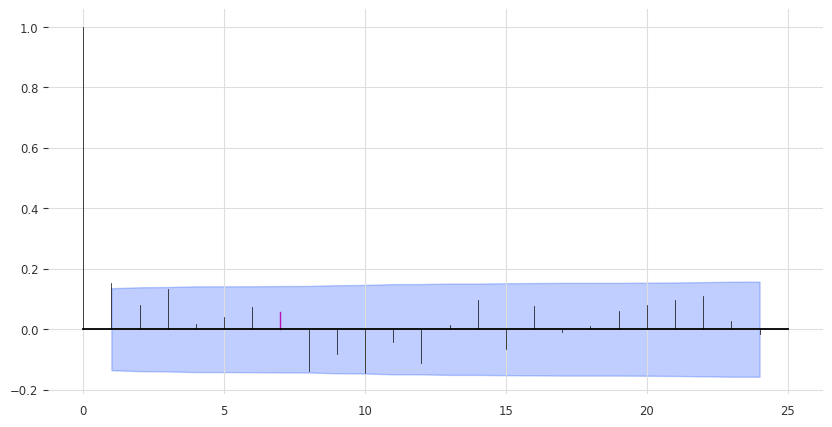

In [26]:
#Check model seasonality
from darts.utils.statistics import plot_acf, check_seasonality
plot_acf(train, m=7, alpha=0.05)
for m in range(2, 12):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

Text(0, 0.5, 'Item Count')

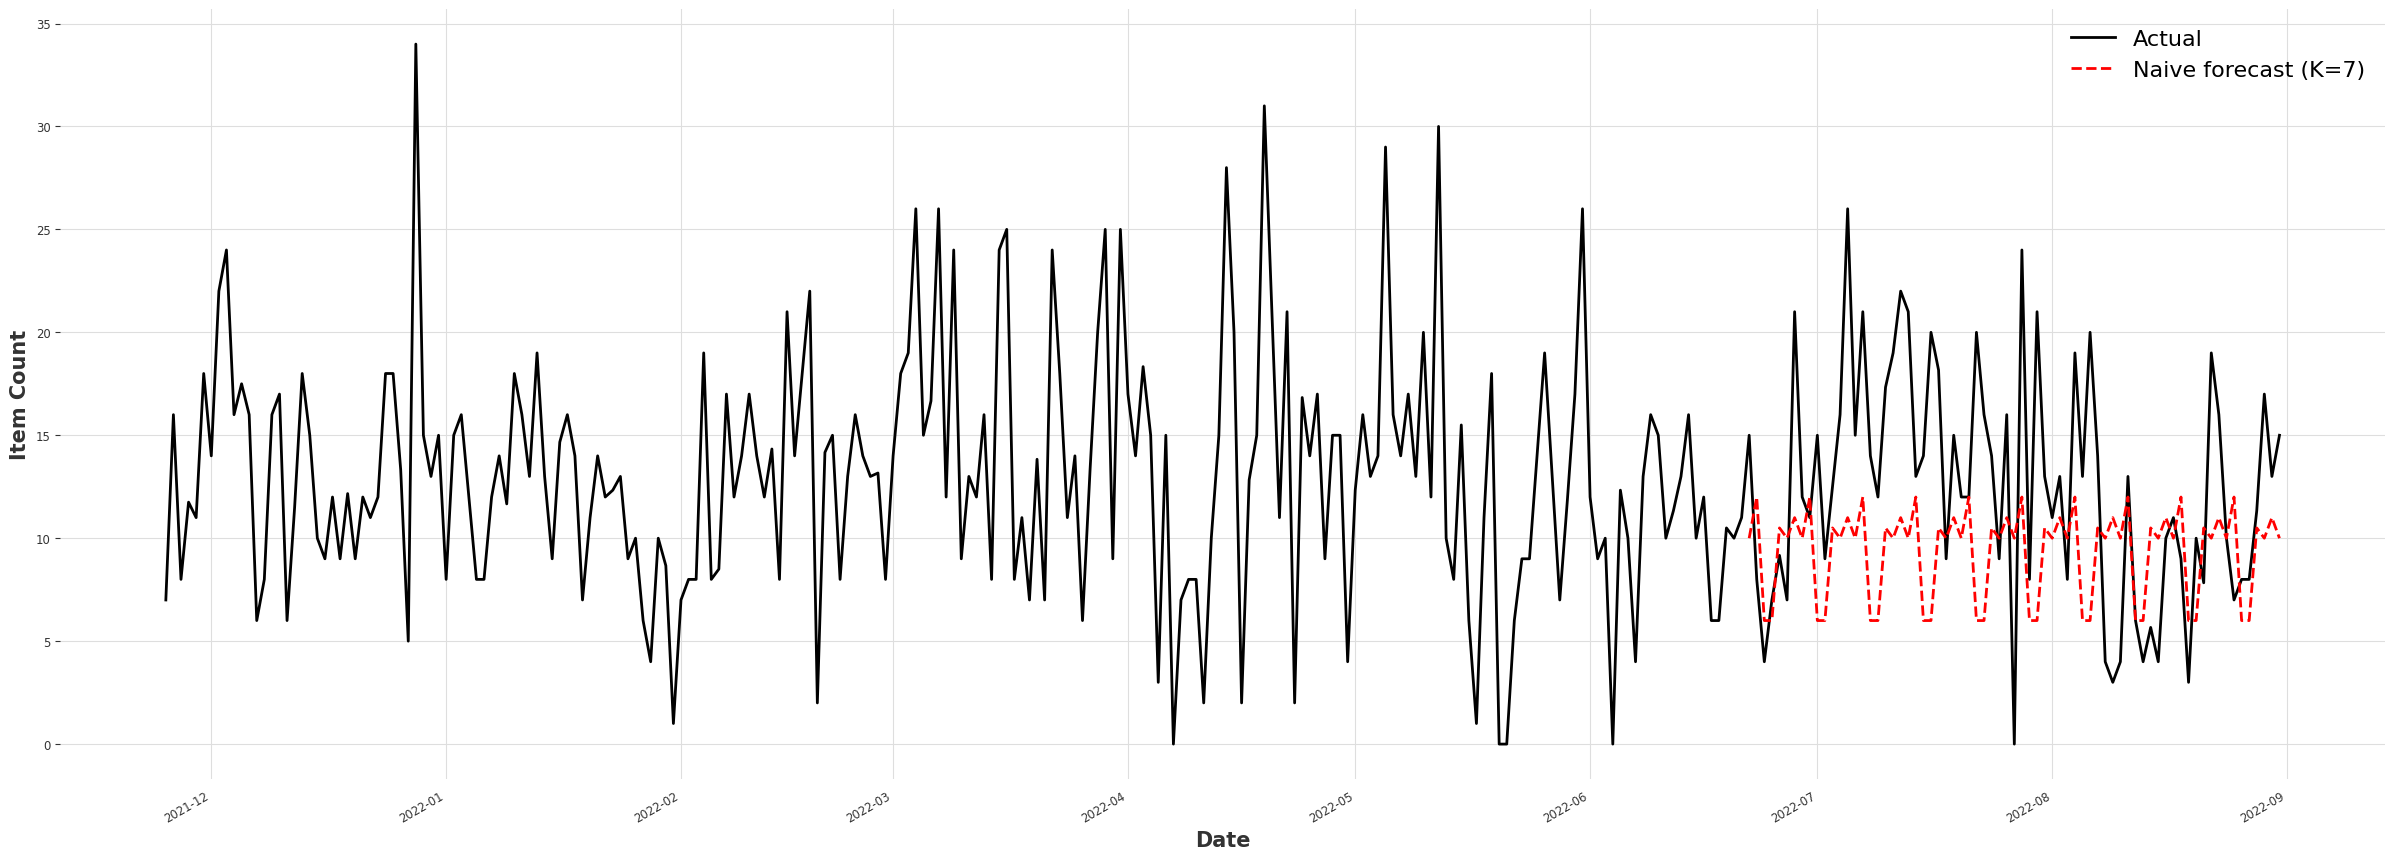

In [27]:
# Naive model for k = 7 seasonality
naive_model = NaiveSeasonal(K=7)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(val))

fig = plt.figure(figsize=(30,10))   
series.plot(label="actual",linestyle = '-', color = 'black')
naive_forecast.plot(label="naive forecast (K=7)",linestyle = '--', color = 'red')
plt.legend(loc=0, prop={'size': 16},labels= ['Actual','Naive forecast (K=7)'])
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Item Count',fontsize = 15)


In [28]:
print("naive model {} MAPE: {:.2f}%".format(naive_model, mape(val, naive_forecast)))

ValueError: The actual series must be strictly positive to compute the MAPE.


ValueError: The actual series must be strictly positive to compute the MAPE.

Text(0, 0.5, 'Item Count')

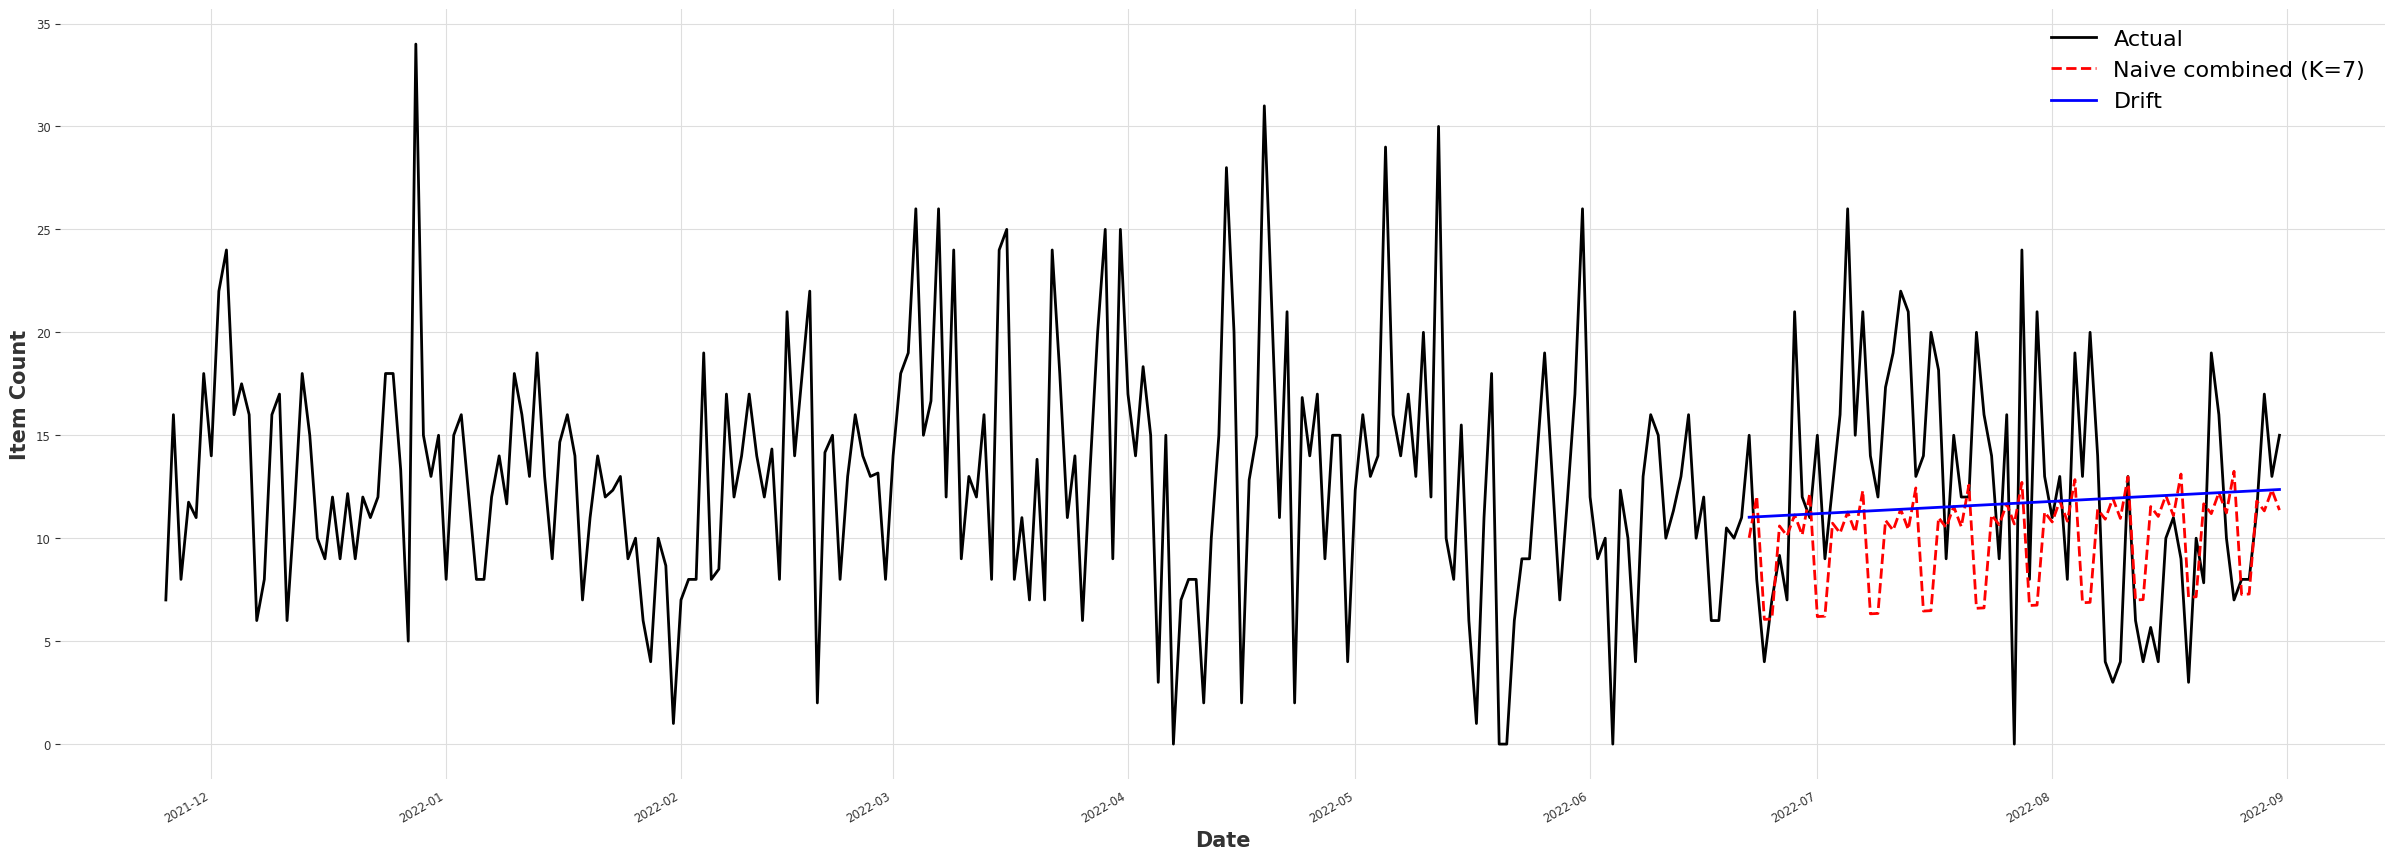

In [29]:
from darts.models import NaiveDrift

naive_drift_model = NaiveDrift()
naive_drift_model.fit(train)
naive_drift_forecast = naive_drift_model.predict(len(val))

naive_combined_forecast = naive_drift_forecast + naive_forecast - train.last_value()



# fig = plt.figure(figsize=(30,10))  
# series.plot()
# naive_combined_forecast.plot(label="combined")
# naive_drift_forecast.plot(label="drift")

fig = plt.figure(figsize=(30,10))   
series.plot(label="actual",linestyle = '-', color = 'black')
naive_combined_forecast.plot(label="naive combined forecast (K=7)",linestyle = '--', color = 'red')
naive_drift_forecast.plot(label="drift",linestyle = '-', color = 'blue')
plt.legend(loc=0, prop={'size': 16},labels= ['Actual','Naive combined (K=7)', 'Drift'])
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Item Count',fontsize = 15)

In [30]:
print("naive model {} MAPE: {:.2f}%".format(naive_drift_model, mape(val, naive_combined_forecast)))

ValueError: The actual series must be strictly positive to compute the MAPE.


ValueError: The actual series must be strictly positive to compute the MAPE.

## Model building

In [ ]:
def eval_model(model,series,train, val):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} MAPE: {:.2f}%".format(model, mape(val, forecast)))
    #print("model {} MASE: {:.2f}.".format(model,mase(val,forecast,train)))
    print("model {} OPE: {:.2f}.".format(model,ope(val, forecast)))
    print("model {} R2: {:.2f}.".format(model,r2_score(val, forecast)))

    fig, ax = plt.subplots(2,figsize=(15, 7.5))
    cycler = plt.cycler(linestyle=['-', '--',], color=['black', 'red'])
    #ax = fig.add_subplot()
    ax[0].set_prop_cycle(cycler)
    ax[1].set_prop_cycle(cycler)

    for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
        label.set_fontsize(18)

    #plt.figure(figsize=(30, 5))
    series.plot(label="Actual", ax = ax[0])
    #val.plot(label="Validation", ax = ax[0])
    forecast.plot(label="Forecast", ax=ax[0])
    ax[0].legend(loc='upper right')
    #plt.show()

    for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
        label.set_fontsize(18)

    #plt.figure(figsize=(30, 5))
    val.plot(label="Validation", ax = ax[1])
    forecast.plot(label="Forecast", ax=ax[1])
    ax[1].legend(loc='upper right')
    ax[1].set_xlim(val.pd_dataframe().index[0], val.pd_dataframe().index[-1])
    #ax[1].set_ylim(0, 0.4)
    #plt.show()


    return model, forecast



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7 MAPE: 28.87%
model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7 OPE: 10.59.
model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7 R2: -0.11.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


model (T)BATS MAPE: 34.15%
model (T)BATS OPE: 17.29.
model (T)BATS R2: -0.41.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


model Auto-ARIMA MAPE: 34.75%
model Auto-ARIMA OPE: 18.09.
model Auto-ARIMA R2: -0.44.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


model Theta(2) MAPE: 28.97%
model Theta(2) OPE: 11.25.
model Theta(2) R2: -0.09.


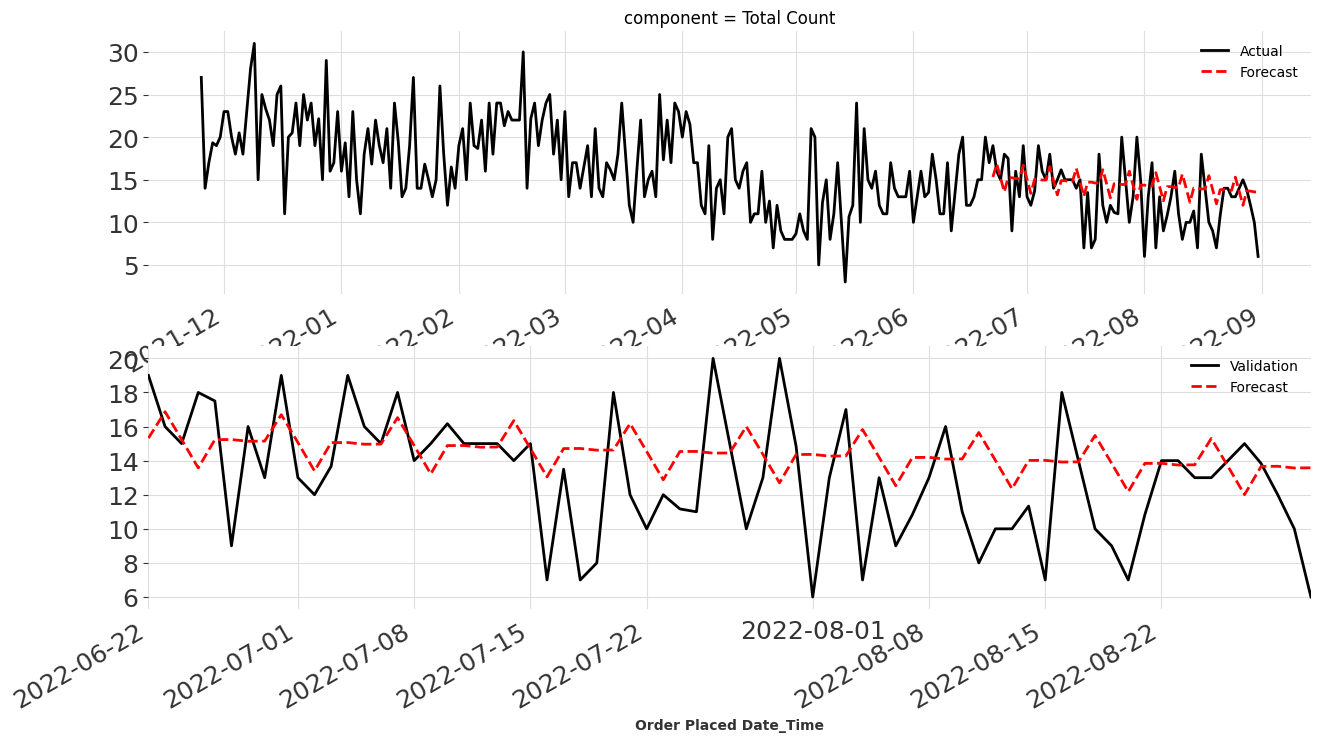

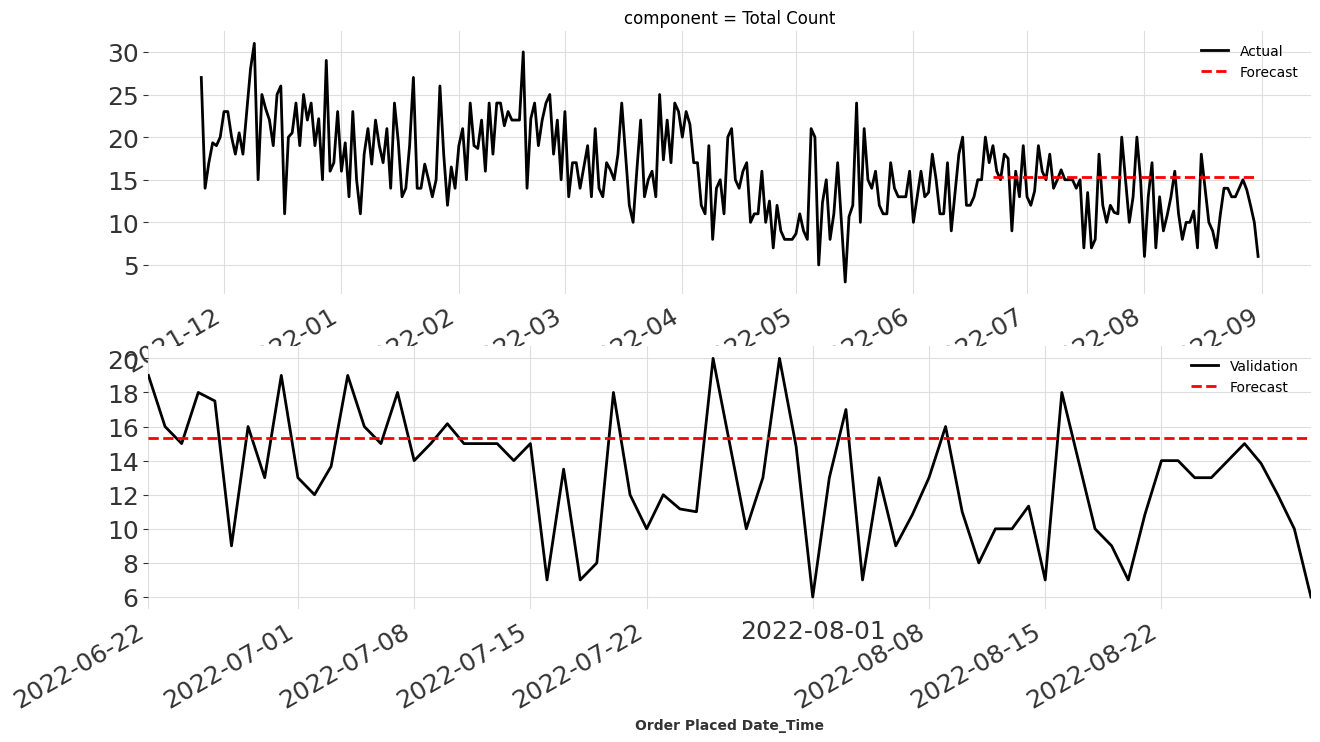

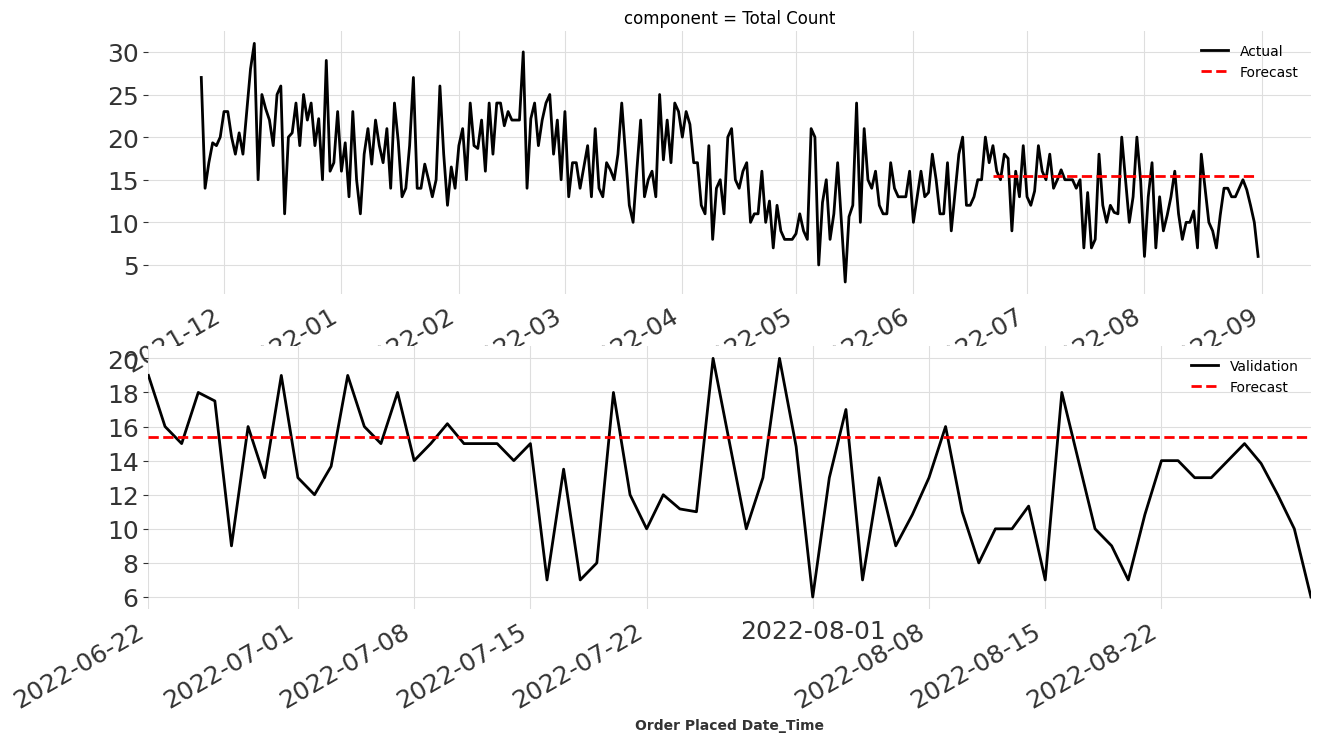

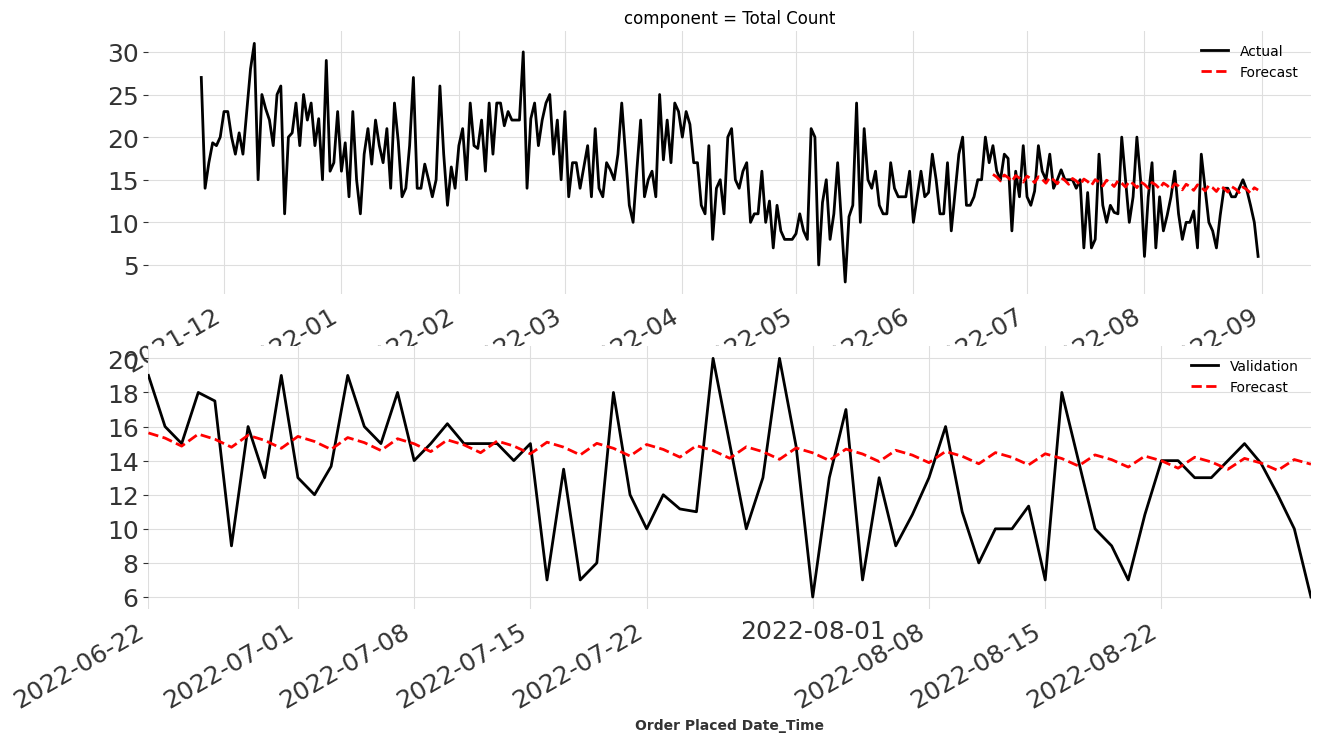

In [ ]:
# Evaluating using typical stats models
ES, forecast = eval_model(ExponentialSmoothing(),series,train,val)
TBATS, forecast = eval_model(TBATS(),series,train,val)
AR, forecast = eval_model(AutoARIMA(),series,train,val)
TH, forecast = eval_model(Theta(),series,train,val)

In [ ]:
# No data scaling
series_scaled = series

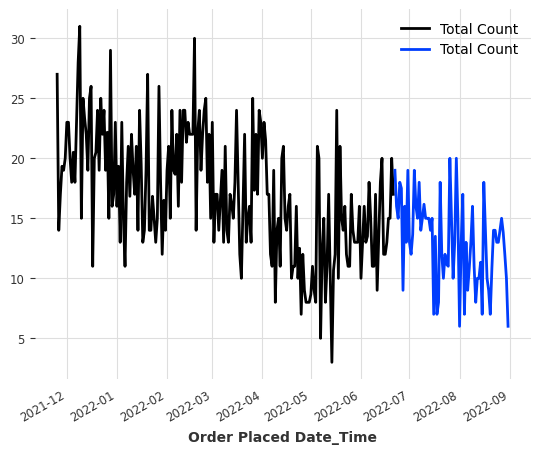

In [ ]:
train, val = series_scaled.split_before(0.75)
train.plot()
val.plot()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
49.819    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 6it [00:00, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


model <darts.models.forecasting.nbeats.NBEATSModel object at 0x00000229976FB280> MAPE: 26.99%
model <darts.models.forecasting.nbeats.NBEATSModel object at 0x00000229976FB280> OPE: 8.63.
model <darts.models.forecasting.nbeats.NBEATSModel object at 0x00000229976FB280> R2: -0.33.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


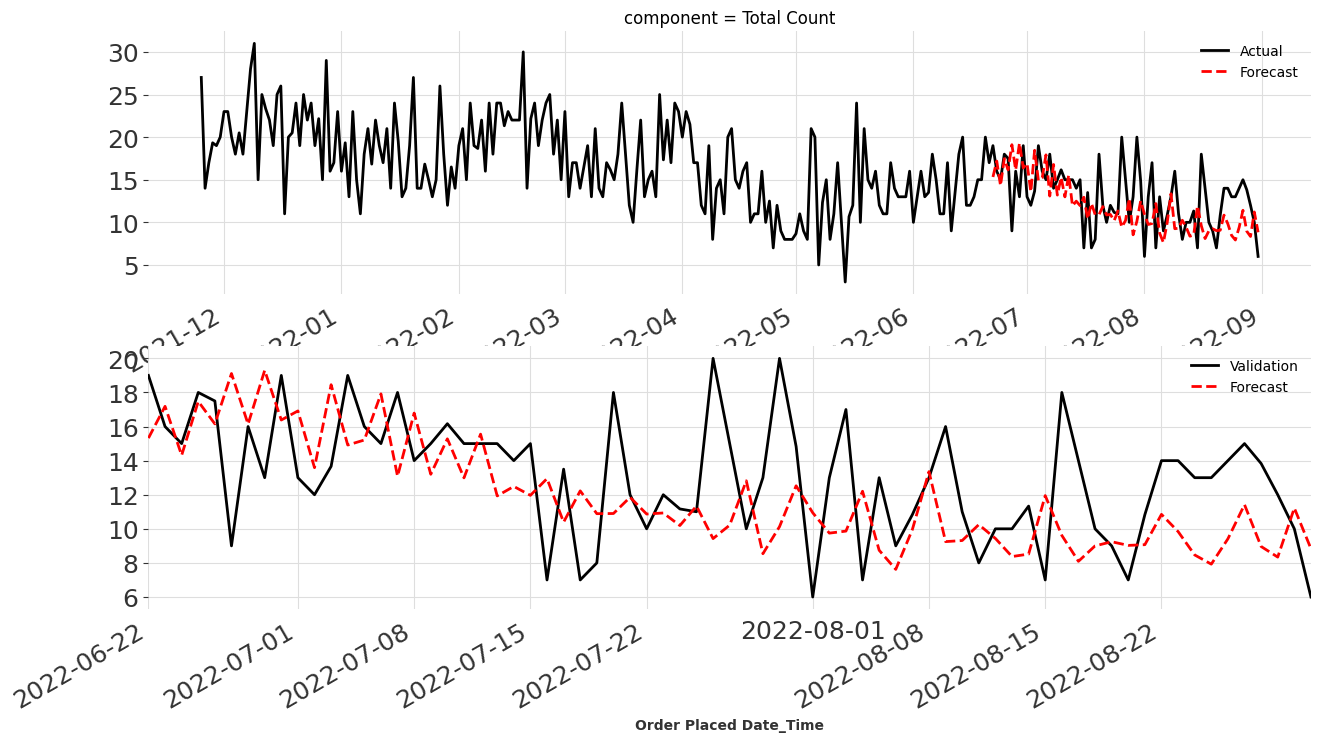

In [ ]:
# Model evaluation using NBeats model
NB, forecast  = eval_model(NBEATSModel(input_chunk_length=28, output_chunk_length=7, n_epochs=100, random_state=0),series_scaled,train,val)

<AxesSubplot:xlabel='Order Placed Date_Time'>

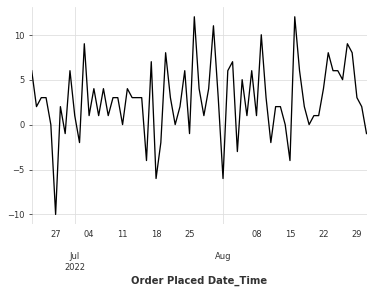

In [ ]:
# Plotting daily error difference
f = forecast.pd_dataframe()
f = f.apply(np.floor)
v = val.pd_dataframe()
d = v['Total Count'] - f['Total Count']
d.plot()

In [ ]:
# Grid search function
def epoch_hpt(ephs):
    model = NBEATSModel(input_chunk_length=28, output_chunk_length=7, n_epochs=ephs, random_state=0)
    model.fit(train, verbose = False)
    forecast = model.predict(len(val))
    mape_err = mape(val, forecast)
    return ephs, mape_err

In [ ]:
# Grid search on epoch numbers for finding least error 
ephs_lst = []
mape_err_lst = []
for i in range(10,50):
    print(i)
    ephs, mape_err = epoch_hpt(i)
    ephs_lst.append(ephs)
    mape_err_lst.append(mape_err)

GPU available: False, used: False


10


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


11


`Trainer.fit` stopped: `max_epochs=11` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


12


`Trainer.fit` stopped: `max_epochs=12` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


13


`Trainer.fit` stopped: `max_epochs=13` reached.


14


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=14` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


15


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


16


`Trainer.fit` stopped: `max_epochs=16` reached.


17


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: False, used: False


18


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=18` reached.
GPU available: False, used: False


19


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: False, used: False


20


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.


21


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=21` reached.
GPU available: False, used: False


22


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=22` reached.


23


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=23` reached.


24


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=24` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


25


HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=25` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


26


`Trainer.fit` stopped: `max_epochs=26` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


27


HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=27` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


28


`Trainer.fit` stopped: `max_epochs=28` reached.


29


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=29` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


30


`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


31


`Trainer.fit` stopped: `max_epochs=31` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


32


`Trainer.fit` stopped: `max_epochs=32` reached.


33


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=33` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


34


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=34` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


35


HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=35` reached.


36


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=36` reached.
GPU available: False, used: False


37


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=37` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


38


`Trainer.fit` stopped: `max_epochs=38` reached.


39


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# Plotting ephochs with mape error
hpt = pd.DataFrame.from_dict({'ephs': ephs_lst, 'mape': mape_err_lst})
hpt.plot(x = 'ephs', y = 'mape')